In [1]:
# ! pip install transformers peft datasets

## Whisper (Web scale pretraining for speech recognition)
 - Fintune the whisper model on specific language datasets
 - taking Hindi as an example
 - can apply LoRA to this as this is a simple transformer under the hood...

In [1]:
# perform the necessary imports

import os
import json
import numpy as np
import torch
from tqdm import tqdm
import wandb
from dataclasses import dataclass

from transformers import AutoModelForSpeechSeq2Seq, AutoTokenizer, AutoFeatureExtractor
from peft import LoraConfig
from datasets import load_dataset, DatasetDict
from datasets import Audio
import evaluate

from transformers import TrainingArguments, Seq2SeqTrainer

from huggingface_hub import login


In [2]:
# load the tokens and secrets
with open('secrets/secrets.json', 'r') as f:
    secrets = json.load(f)

# login with the secrets

login(token=secrets['HF_TOKEN'], add_to_git_credential=True, write_permission=True)
wandb.login(key=secrets['WANDB_TOKEN'])


%env WANDB_PROJECT='whisper_small.hindi'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/ostrich/.cache/huggingface/token
Login successful


wandb: Currently logged in as: parth-shastri. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ostrich/.netrc


env: WANDB_PROJECT='whisper_small.hindi'


### Load the Model

In [4]:
model_name = 'openai/whisper-small'   # experimenting with the small model

model = AutoModelForSpeechSeq2Seq.from_pretrained(model_name)
# Define the tokenizer and the feature_processor, the language and the task are defined later.
tokenizer = AutoTokenizer.from_pretrained(model_name)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
model.generation_config.language = 'hindi'
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None

In [6]:
# look at the model architecture &/or config
# model

# model.generation_config
# model.config

# feature_extractor

# tokenizer

### Load the dataset and prepare the tokenizers

In [3]:
common_voice = DatasetDict()

common_voice['train'] = load_dataset('mozilla-foundation/common_voice_11_0', 'hi', split='train+validation', trust_remote_code=True)
common_voice["test"] = load_dataset(
    "mozilla-foundation/common_voice_11_0", "hi", split="test", trust_remote_code=True
)

In [4]:
common_voice

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 6540
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 2894
    })
})

In [5]:
common_voice = common_voice.remove_columns(
    [
        "client_id",
        "accent",
        "age",
        "down_votes",
        "up_votes",
        "gender",
        "locale",
        "path",
        "segment",
        # 'audio'
    ]
)

In [10]:
# Tokenizer set the prefix task/language tokens
tokenizer.set_prefix_tokens(language='hindi', task='transcribe')
input_str = common_voice["train"][0]["sentence"]
labels = tokenizer(input_str, add_special_tokens=True).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                 हमने उसका जन्मदिन मनाया।
Decoded w/ special:    <|startoftranscript|><|hi|><|transcribe|><|notimestamps|>हमने उसका जन्मदिन मनाया।<|endoftext|>
Decoded w/out special: हमने उसका जन्मदिन मनाया।
Are equal:             True


In [6]:
# Deal with the audio part
print(common_voice['train'][0])
# req. Parameters: 
                # array, sampling_rate, sentence

{'audio': {'path': '/home/ostrich/.cache/huggingface/datasets/downloads/extracted/97656aa091898f5a90a0733567ad6dcc4953df9e1fce8e3748fd96a0f5063823/hi_train_0/common_voice_hi_26008353.mp3', 'array': array([ 5.81611368e-26, -1.48634016e-25, -9.37040538e-26, ...,
        1.06425901e-07,  4.46416450e-08,  2.61450239e-09]), 'sampling_rate': 48000}, 'sentence': 'हमने उसका जन्मदिन मनाया।'}


In [7]:
# Lets change the sampling rate to the models sampling rate
common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

In [8]:
print(common_voice["train"])

Dataset({
    features: ['audio', 'sentence'],
    num_rows: 6540
})


### Listen to Audio sample

In [9]:
from IPython.display import Audio, display

audio_sample = common_voice['train'][0]['audio']['array']
sampling_rate = common_voice['train'][0]['audio']['sampling_rate']
display(Audio(data=audio_sample, rate=sampling_rate))
print(common_voice["train"][0]["audio"]["array"].shape)

(65088,)


In [16]:
def prepare_dataset(batch):
    """
    Mapping function to tokenize and process the audio 
    Parameters:
    -----------
        batch: Dict, 
    Returns:
    --------
        mapped_batch
    """
    # audio = batch['audio']

    audio_arrays = [x['array'] for x in batch['audio']]

    sampling_rate = batch['audio'][0]['sampling_rate']

    inputs = feature_extractor(
        audio_arrays, sampling_rate=sampling_rate
    ).input_features

    labels = tokenizer(batch['sentence']).input_ids

    return {'input_features': inputs, 'labels': labels}

In [17]:
common_voice["train"] = common_voice["train"].map(prepare_dataset, remove_columns=['audio', 'sentence'], batched=True,)
common_voice["test"] = common_voice["test"].map(
    prepare_dataset, remove_columns=['audio', 'sentence'], batched=True,
)

### Visualize the Mel Spectrogram (n=80)

(80, 3000)

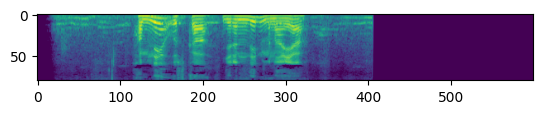

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots()
x = np.array(common_voice['train'][0]['input_features'])
axs.imshow(x[..., :600])

x.shape

### Data collation and padding

In [19]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    feature_extractor: any
    tokenizer: any
    decoder_start_token_id: int

    def __call__(self, features):

        input_features = [{
            "input_features": feature['input_features'] 
        } for feature in features]
        batch = self.feature_extractor.pad(input_features, return_tensors='pt')

        label_features = [{"input_ids": feature['labels']} for feature in features]

        labels_batch = self.tokenizer.pad(label_features, return_tensors='pt')

        labels = labels_batch['input_ids'].masked_fill(labels_batch.attention_mask != 1, -100)

        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]
        
        batch['labels'] = labels

        return batch

In [20]:
datacollator = DataCollatorSpeechSeq2SeqWithPadding(feature_extractor, tokenizer, decoder_start_token_id=model.config.decoder_start_token_id)


### Define the evaluation metric
 - WER is the defacto

In [21]:
metric = evaluate.load('wer')

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Training 

In [22]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./models/whisper_small.hi",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=3e-4,
    warmup_steps=500,
    max_steps=5000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy='steps',
    per_device_eval_batch_size=8,
    predict_with_generate=True, 
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=['wandb'],
    load_best_model_at_end=True,
    metric_for_best_model='wer',
    greater_is_better=False,
    push_to_hub=True,
    dataloader_num_workers=4
)

In [29]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice['train'],
    eval_dataset=common_voice['test'],
    data_collator=datacollator,
    compute_metrics=compute_metrics,
    tokenizer = tokenizer,
)

/home/ostrich/anaconda3/envs/my_master/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [30]:
# finetune

# suppress the parallelism warning
os.environ['TOKENIZER_PARALLELISM'] = True
# os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = True

# Init the run
run = wandb.init(project='whisper_small.hindi')

# Run the Finetune
trainer.train()
trainer.save_model()

# Finish the run
run.finish()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Step,Training Loss,Validation Loss,Wer
1000,0.275500,0.672379,64.149666
2000,0.147300,0.610962,57.385931
3000,0.045100,0.689744,54.414628
4000,0.007400,0.694505,51.075087
5000,0.000300,0.697315,47.329214


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

eval/loss,▆▁▇██
eval/runtime,▄█▁▄▁
eval/samples_per_second,▅▁█▅█
eval/steps_per_second,▅▁█▅█
eval/wer,█▅▄▃▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,▅▅▄█▄▄▄▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▂▃▅▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,▇▇▇██▇▇▅▅▅▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.69732


In [ ]:
tokenizer.save_pretrained(f'tokenizers/{model_name}')

### Inference

In [13]:
from transformers import pipeline

model = AutoModelForSpeechSeq2Seq.from_pretrained('./models/whisper_small.hi')
tokenizer = AutoTokenizer.from_pretrained('./models/whisper_small.hi')
feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-small")

pipe = pipeline(
    task="automatic-speech-recognition",
    model=model,
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
    # max_new_tokens=128,
    # chunk_length_s=30,
    # batch_size=16,
    # return_timestamps=False,
    # torch_dtype=torch.float,
    # device=device,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
# Check the tokenizer input
input_str = common_voice["train"][0]["sentence"]
labels = tokenizer(input_str, add_special_tokens=True).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                 हमने उसका जन्मदिन मनाया।
Decoded w/ special:    <|startoftranscript|><|hi|><|transcribe|><|notimestamps|>हमने उसका जन्मदिन मनाया।<|endoftext|>
Decoded w/out special: हमने उसका जन्मदिन मनाया।
Are equal:             True


In [17]:
# Optional test audio 
display(Audio(common_voice['test'][0]['audio']['array'], rate=16000))

In [16]:
pipe(common_voice['test'][0]['audio']['array'])
# Looks good

{'text': 'वराण सिंहिंसा पुलिस की भूमिका संदिक्त्र, बायरल हुई तस्वीरें'}